In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allensdk
import pickle
import pprint
from sklearn.decomposition import PCA
from rep_drift import *

In [95]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [96]:
n_sessions = 3
n_divs = 30
n_repeats = 10

In [97]:
def correlation_across_sessions(cell_ids_experiments, dff_vals_experiments, n_sessions = 3, n_divs = 30):
    '''
    Obtains the correlation across sessions given data for a *single* container.
    
    Args
    ------
    cell_ids_experiments: list where each element is a np.array of cell_ids for a particular session
    dff_vals_experiments: list where each element is a np.array of dff_vals for a particular session

    
    Returns
    -------
    (tuple) across_session_corrs, across_session_angles
    '''
    
    unique_cell_ids = get_unique_cell_ids(cell_ids_experiments)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids)
    
    across_session_corrs = np.zeros((n_sessions*n_divs, n_sessions*n_divs))
    across_session_angles = np.zeros((n_sessions*n_divs, n_sessions*n_divs))
    
    avg_dff_vals = []
    
    # Collect avg dff for all sessions
    for session_idx in range(n_sessions):
        dff_vals_session = dff_vals_experiments[session_idx] 
        avg_dff_of_session = np.mean(dff_vals_session[:,:, shared_cell_idxs[session_idx]], axis = 0)
        avg_dff_vals.append(avg_dff_of_session)
    
    for session_i in range(n_sessions):
        for session_j in range(n_sessions):
            
            corr = np.corrcoef(avg_dff_vals[session_i], avg_dff_vals[session_j])[n_divs: , :n_divs]
            
            across_session_corrs[
                session_i * n_divs : (session_i + 1) * n_divs,
                session_j * n_divs : (session_j + 1) * n_divs ] = corr
            for div_i in range(n_divs):
                for div_j in range(n_divs):
                    across_session_angles[
                        session_i * n_divs + div_i,
                        session_j * n_divs + div_j] = alignment_angle(avg_dff_vals[session_i][div_i], avg_dff_vals[session_j][div_j]
                                      )
                        
    return across_session_corrs, across_session_angles

def get_unique_cell_ids(cell_ids_experiment):
    '''
    Finds all unique cell_ids. For each unique cell_id, creates a list of 
    corresponding indexes in datasets
    '''
    
    unique_cell_ids = {}

    for cell_ids in cell_ids_experiment:
        for cell_idx, cell_id in enumerate(cell_ids):
            if cell_id not in unique_cell_ids.keys():
                unique_cell_ids[cell_id] = []

    # For each cell_id, finds the indexes in all experimental datasets
    # (lists index as nan if not in given dataset.
    for cell_id in unique_cell_ids.keys():
        for cell_ids in cell_ids_experiment:
            if cell_id in cell_ids:
                # unique_cell_ids[cell_id].append(cell_ids.index(cell_id))
                unique_cell_ids[cell_id].append(np.where(cell_ids == cell_id)[0][0])
            else:
                unique_cell_ids[cell_id].append(np.nan)

    return unique_cell_ids

def get_shared_cell_idxs(unique_cell_ids, verbose=True):
    '''
    Finds all cell_ids shared across the datasets, and then returns a numpy 
    array which has the idx of said cell_ids in each dataset.
    '''
    n_exp = len(unique_cell_ids[list(unique_cell_ids.keys())[0]])

    shared_cell_ids = []
    for cell_id in unique_cell_ids.keys():
        if np.sum(np.isnan(unique_cell_ids[cell_id])) == 0:
            shared_cell_ids.append(cell_id)

    if verbose:
        print('Shared IDs: {}/{}'.format(len(shared_cell_ids), 
                                        len(unique_cell_ids.keys())))

    # Map of shared cell_ids to cell_idxs in both datasets
    shared_cell_idxs = np.zeros((n_exp, len(shared_cell_ids)), dtype=np.int64)
    for cell_idx, cell_id in enumerate(shared_cell_ids):
        shared_cell_idxs[:, cell_idx] = unique_cell_ids[cell_id]

    return shared_cell_idxs

In [98]:
boc = BrainObservatoryCache()
datasets, ordered_days = get_datasets(boc, 540993888)

In [99]:
session_dff_vals = []
session_cell_ids = []
session_run_vals = []

for dataset in datasets:
    cell_ids, dff_vals, run_vals = get_response_vals(dataset)
    session_dff_vals.append(dff_vals)
    session_cell_ids.append(cell_ids)
    session_run_vals.append(run_vals)

In [100]:
# Applying MDS: First obtain correct shape for each stimulus group
print(session_cell_ids[0].shape)

(140,)


In [101]:
unique_cell_ids = get_unique_cell_ids(session_cell_ids)
shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids)

stimulus_groups = [[None, None, None]] * 30
collapsed_stimulus_groups = []

for session_idx in range(n_sessions):
    cur = session_dff_vals[session_idx]
    for n_div in range(0, 30):
        stimulus_groups[n_div][session_idx] = cur[:, n_div, shared_cell_idxs[session_idx]]

for idx in range(0, len(stimulus_groups)):
    collapsed_stimulus_groups.append(np.vstack(stimulus_groups[idx]))

Shared IDs: 29/302


In [102]:
print(collapsed_stimulus_groups[0].shape)

(30, 29)


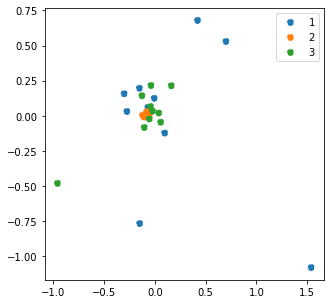

In [104]:
# Plot eucliden distances for a given stimulus group
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

X = collapsed_stimulus_groups[0]

fig, ax = plt.subplots(figsize = (5,5))

mds = MDS(n_components = 2, metric = False, max_iter = 3000)
pos = mds.fit_transform(X).T

session1 = pos[:, :10]
session2 = pos[:, 10:20]
session3 = pos[:, 20:30]

plt.scatter(session1[0], session1[1], label = "1",  ls = '--')
plt.scatter(session2[0], session2[1], label = "2", ls = '--')
plt.scatter(session3[0], session3[1], label = "3",  ls = '--')
plt.legend()
plt.savefig('./mds_sample.png')

In [79]:
# Using a correlation matrix

def alignment_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)


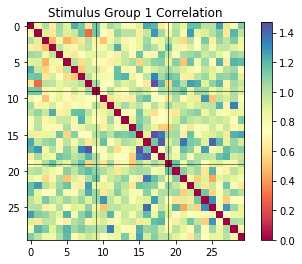

In [130]:
session_corrs = np.corrcoef(collapsed_stimulus_groups[4])
distance = 1 - session_corrs

fig, ax = plt.subplots()
ax.set_title("Stimulus Group 1 Correlation")
cplot = ax.imshow(distance, cmap = 'Spectral')
for session_idx in range(1, n_sessions):
    ax.axhline((session_idx * 10)-1, color='k', linewidth=0.5)
    ax.axvline((session_idx * 10)-1, color='k', linewidth=0.5)
plt.colorbar(cplot, ax = ax)

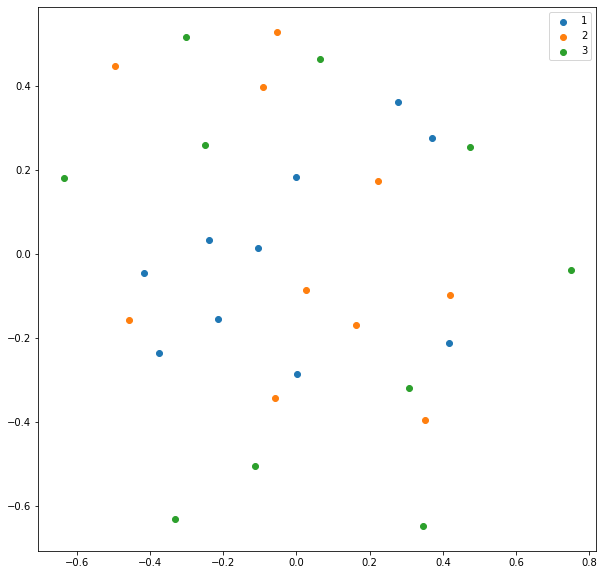

In [116]:
mds = MDS(n_components=2, metric = False, dissimilarity = "precomputed")
pos = mds.fit_transform(distance).T

session1 = pos[:, :10]
session2 = pos[:, 10:20]
session3 = pos[:, 20:30]

plt.figure(figsize = (10,10))
plt.scatter(session1[0], session1[1], label = "1")
plt.scatter(session2[0], session2[1], label = "2")
plt.scatter(session3[0], session3[1], label = "3")
plt.legend()